In [27]:
import rasterio
from rasterio.plot import show
from rasterio.plot import show_hist
from rasterio.mask import mask

from shapely.geometry import box

import geopandas as gpd

from fiona.crs import from_epsg

import pycrs

In [28]:
# Filepaths
fp = "out/out_kaunas_sentinel.tif"

out_tif = "out/cutout_kaunas.tif"

In [29]:
data = rasterio.open(fp)

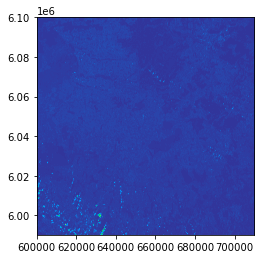

<AxesSubplot:>

In [30]:
show((data, 3), cmap='terrain')

In [37]:
# WGS84 coordinates
minx, miny = 54.8217649993685, 23.7922346
maxx, maxy = 54.9597227994084, 24.0968447
bbox = box(minx, miny, maxx, maxy)

In [49]:
data.crs.data

{'init': 'epsg:4326'}

In [50]:
geo = gpd.GeoDataFrame({'geometry': bbox}, index=[0], crs=from_epsg(4326))

In [39]:
geo = geo.to_crs(crs=data.crs.data)

ValueError: Cannot transform naive geometries.  Please set a crs on the object first.

In [51]:
def getFeatures(gdf):
    """Function to parse features from GeoDataFrame in such a manner that rasterio wants them"""
    import json
    return [json.loads(gdf.to_json())['features'][0]['geometry']]


In [52]:
coords = getFeatures(geo)

print(coords)


[{'type': 'Polygon', 'coordinates': [[[54.9597227994084, 23.7922346], [54.9597227994084, 24.0968447], [54.8217649993685, 24.0968447], [54.8217649993685, 23.7922346], [54.9597227994084, 23.7922346]]]}]


In [53]:
out_img, out_transform = mask(data, coords, crop=True)

ValueError: Input shapes do not overlap raster.

In [54]:
# Copy the metadata
out_meta = data.meta.copy()

print(out_meta)
{'driver': 'GTiff', 'dtype': 'uint8', 'nodata': None, 'width': 8877, 'height': 8106, 'count': 7, 'crs': CRS({'init': 'epsg:32634'}), 'transform': (600466.5, 28.5, 0.0, 6784966.5, 0.0, -28.5), 'affine': Affine(28.5, 0.0, 600466.5,
       0.0, -28.5, 6784966.5)}

{'driver': 'GTiff', 'dtype': 'uint16', 'nodata': None, 'width': 10980, 'height': 10980, 'count': 3, 'crs': CRS.from_epsg(4326), 'transform': Affine(10.0, 0.0, 600000.0,
       0.0, -10.0, 6100020.0)}


NameError: name 'CRS' is not defined

In [ ]:
# Parse EPSG code
epsg_code = int(data.crs.data['init'][5:])

print(epsg_code)
32634

In [ ]:
out_meta.update({"driver": "GTiff",
                  "height": out_img.shape[1],
                  "width": out_img.shape[2],
                  "transform": out_transform,
                  "crs": pycrs.parser.from_epsg_code(epsg_code).to_proj4()}
                          )
 

In [ ]:
with rasterio.open(out_tif, "w", **out_meta) as dest:
     dest.write(out_img)


In [ ]:
clipped = rasterio.open(out_tif)

show((clipped, 5), cmap='terrain')
